# Reprojecting, stacking and colour-combination

On this page we'll reproject our pre-reduced exposures on a common pixel grid, stack them, and produce a colour image.

You can copy or write the code shown below in a script, or alternatively directly download this page as a {download}`jupyter notebook <./stack.ipynb>` file.

To run the code, you'll need the module `dataredconfig.py`, as explained [here](./data.md).

In [1]:

import dataredconfig

import numpy as np
import astropy
import astropy.visualization
from astropy import units as u

%matplotlib ipympl
import matplotlib
from matplotlib import pyplot as plt
import ccdproc


In [2]:

light_prered_dir = dataredconfig.work_dir / "LIGHT_PRERED"
science_files = ccdproc.ImageFileCollection(light_prered_dir, keywords=dataredconfig.ifc_header_keywords)

# Let's first get an overview of all available files:
science_files.summary

/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "_p_order", the pair "_p_order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits" contains multiple entries for "__order", the pair "__order=3.0" will be i

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2
str45,str5,str1,float64,str4,int64,int64,int64,int64
2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
2024-03-08_22-06-39_r_-10.00_60.00s_0002.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
2024-03-08_22-07-43_g_-10.00_60.00s_0000.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
2024-03-08_22-08-45_g_-10.00_60.00s_0001.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
2024-03-08_22-09-47_g_-10.00_60.00s_0002.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
2024-03-08_22-10-51_i_-10.00_60.00s_0000.fits,LIGHT,i,60.0,M 37,2,2,4788,3194
2024-03-08_22-11-53_i_-9.90_60.00s_0001.fits,LIGHT,i,60.0,M 37,2,2,4788,3194
2024-03-08_22-12-55_i_-10.00_60.00s_0002.fits,LIGHT,i,60.0,M 37,2,2,4788,3194


In [3]:
# Where to write the reprojected files:
dest_dir = dataredconfig.work_dir / "REPROJ"
dest_dir.mkdir(exist_ok=True)


Rerun the following three cells with all filters:

In [11]:

# Select object and filter:
selected_object = "M 37"
selected_filter = "r"

selected_science_files = science_files.filter(object=selected_object, filter=selected_filter)
selected_science_files.summary

/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "_p_order", the pair "_p_order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits" contains multiple entries for "__order", the pair "__order=3.0" will be i

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2
str109,str5,str1,float64,str4,int64,int64,int64,int64
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-06-39_r_-10.00_60.00s_0002.fits,LIGHT,r,60.0,M 37,2,2,4788,3194


In [12]:
# Select first image as the target to project on (note: same image for *all* filters!)
target_image = ccdproc.CCDData.read(science_files.filter(object=selected_object).files[0])

# Looping over the images to do the reprojection (takes a while):
for ccd, filename in selected_science_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"Reprojecting {filename}...")
    
    ccd = ccdproc.wcs_project(ccd, target_image.wcs)

    # Write to disk:
    ccd.data = ccd.data.astype('float32')
    ccd.write(dest_dir / filename, overwrite=True)


/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "_p_order", the pair "_p_order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits" contains multiple entries for "__order", the pair "__order=3.0" will be i

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Reprojecting 2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits...


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Reprojecting 2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits...


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Reprojecting 2024-03-08_22-06-39_r_-10.00_60.00s_0002.fits...


In [13]:
# Combine the reprojected images of that filter:

files_to_combine = ccdproc.ImageFileCollection(dest_dir).files_filtered(object=selected_object, filter=selected_filter, include_path=True)
ccd = ccdproc.combine(files_to_combine,
                        method='average', scale=None,
                        sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                        sigma_clip_func=np.ma.median, signma_clip_dev_func=astropy.stats.mad_std,
                        mem_limit=1e9
                    )

ccd.meta['combined'] = True
ccd.data = ccd.data.astype('float32') # Converts to float32 to save space
ccd.write(dataredconfig.work_dir / f"combi_{selected_object}_{selected_filter}.fits", overwrite=True)


/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/REPROJ/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/REPROJ/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "_p_order", the pair "_p_order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/REPROJ/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings

INFO: splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]


## Colour-combination

This is the colour-combination algorithm used by SDSS.
It might not be "optimal" for pretty pictures (well that's a matter of taste), but it is scientifically interesting.

Todo: describe more, and also compare with simple RGB composite.

In [15]:

g_ccd = ccdproc.CCDData.read(dataredconfig.work_dir / f"combi_{selected_object}_g.fits")
r_ccd = ccdproc.CCDData.read(dataredconfig.work_dir / f"combi_{selected_object}_r.fits")
i_ccd = ccdproc.CCDData.read(dataredconfig.work_dir / f"combi_{selected_object}_i.fits")

# i -> R
i_ccd.data *= 1.0
# r -> G
r_ccd.data *= 0.4
# g -> B
g_ccd.data *= 0.3

sky_levels = (np.nanmedian(i_ccd.data), np.nanmedian(r_ccd.data), np.nanmedian(g_ccd.data))

rgbimage = astropy.visualization.make_lupton_rgb(i_ccd.data, r_ccd.data, g_ccd.data,
                                                 minimum=1.0*np.array(sky_levels),
                                                 stretch=30, Q=5, 
                                                 filename=dataredconfig.work_dir/f"combi_{selected_object}.jpg")

# Note that this both returns the image as a numpy array, and writes it to jpg.

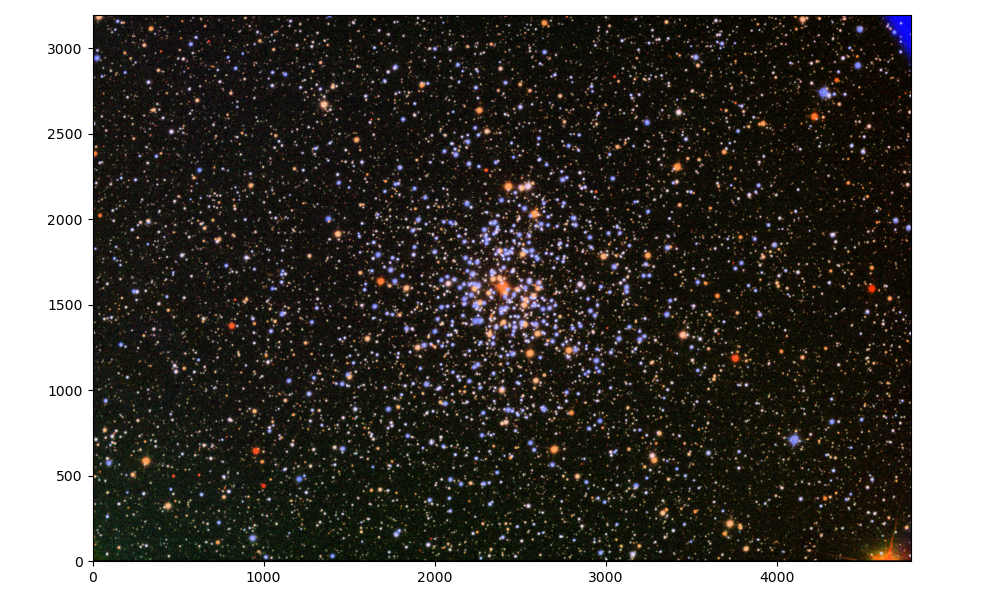

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
ax.imshow(rgbimage , origin="lower")
fig.tight_layout()
plt.show()

In [ ]:
# If needed, one can also write the image manually for example with matplotlib:
#import matplotlib.image
#matplotlib.image.imsave("rgbimage.png", rgbimage, origin="lower")